In [21]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns       
import pandas as pd                           # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats
from iminuit.cost import LeastSquares
from scipy import optimize
from scipy.stats import kstest
from scipy.stats import poisson

sys.path.append('../External_Functions')
sys.path.append('../JonathansFunctions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure
from JonathansFunctions import *

plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

# Problem 3

In [22]:
r = np.random
r.seed(42)

save_plots = False   
N_points = 10000      # Number of random points to be produced!

xmin = 0.005
xmax = 1.0
N_bins = 100

def fx_2x(x) :
    # Normalization is N_points * binwidth:
    k = (xmax - xmin) / N_bins
    N = N_points * k
    return N*0.243*x**(-0.9)

In [23]:
N_try = 0
ymin = 0.0      # Minimum value the function will take!
ymax = 29.0      # Maximum value the function will take!
x_accepted = np.zeros(N_points)

for i in range(N_points):
    
    while True:
        
        # Count the number of tries, to get efficiency/integral
        N_try += 1                    
        
        # Range that f(x) is defined/wanted in:
        x_test = r.uniform(xmin, xmax)  
        
        # Upper bound for function values:
        y_test = r.uniform(ymin, ymax)
        
        if (y_test < 0.2431*x_test**(-0.9)):
            break
            
    x_accepted[i] = x_test

In [24]:
# Efficiency
eff = N_points / N_try                        

# Error on efficiency (binomial!)
eff_error = np.sqrt(eff * (1-eff) / N_try) 

# Integral
integral =  eff * (xmax-xmin) * (ymax-ymin)

# Error on integral
eintegral = eff_error * (xmax-xmin) * (ymax-ymin)  

print(f"\nIntegral of f(x) = x, x in [0, 1] is: \t {integral:7.4f} +- {eintegral:6.4f}")
print(f"The efficiency of the Accept/Reject method used here is: \t {eff:.2%} +/- {eff_error:.2%}")
# We normalized the function ahead of time, so we should hope to get a result consistent with unity!


Integral of f(x) = x, x in [0, 1] is: 	  0.9965 +- 0.0098
The efficiency of the Accept/Reject method used here is: 	 3.45% +/- 0.03%


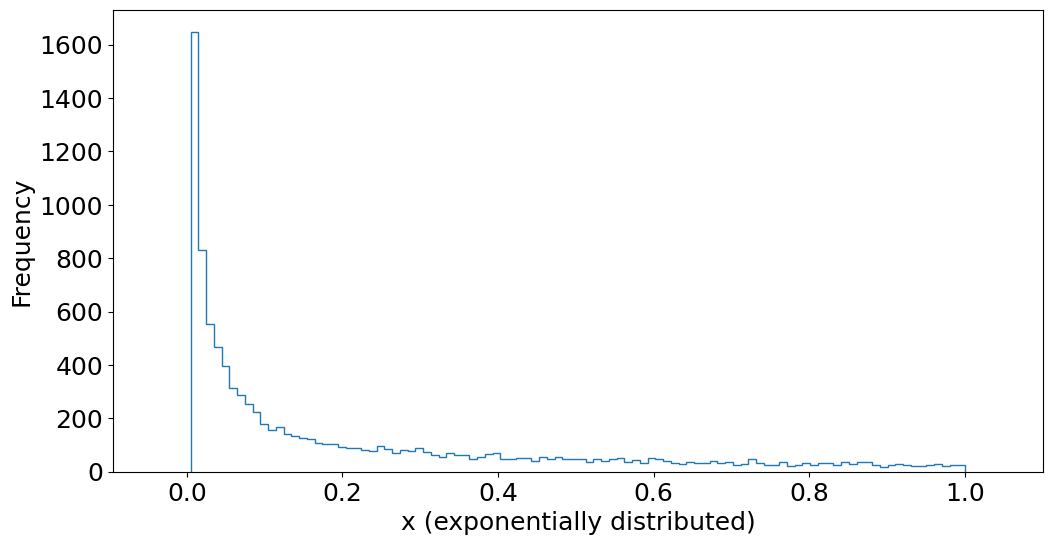

In [25]:
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.hist(x_accepted, bins=N_bins, range=(xmin, xmax), histtype='step', label='histogram' )
ax2.set(xlabel="x (exponentially distributed)", ylabel="Frequency", xlim=(xmin-0.1, xmax+0.1));

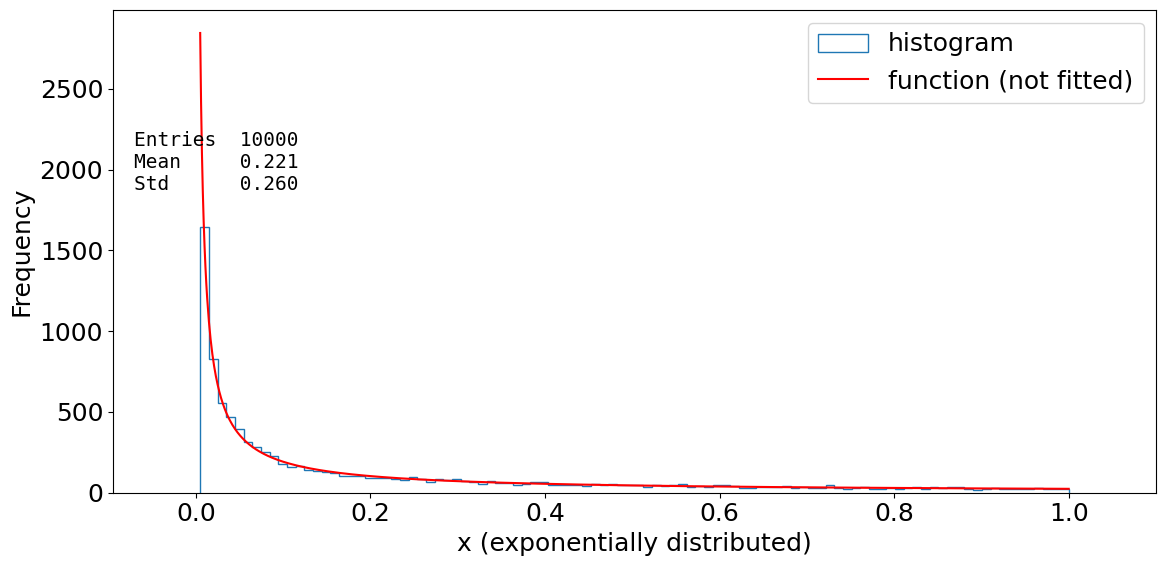

In [26]:
# Plot f(x)
x_axis2 = np.linspace(xmin, xmax, 1000)
y_axis2 = fx_2x(x_axis2)
ax2.plot(x_axis2, y_axis2, 'r-', label='function (not fitted)')

# Define the figure text
d2 = {'Entries': len(x_accepted),
      'Mean': x_accepted.mean(),
      'Std': x_accepted.std(ddof=1),
    }

# Add figure text
text2 = nice_string_output(d2, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.75, text2, ax2, fontsize=14)

# Add legend
ax2.legend(loc='best')
fig2.tight_layout()

# Save figure
if save_plots: 
    fig2.savefig("Hist_2x_AcceptRejectMethod.pdf", dpi=600)
    
# Show the figure
fig2

In [27]:
t = []
for j in range(1000):
	r_val = np.sum(np.random.choice(x_accepted, 50))
	t.append(r_val)
t = np.array(t)
print(len(t))

1000


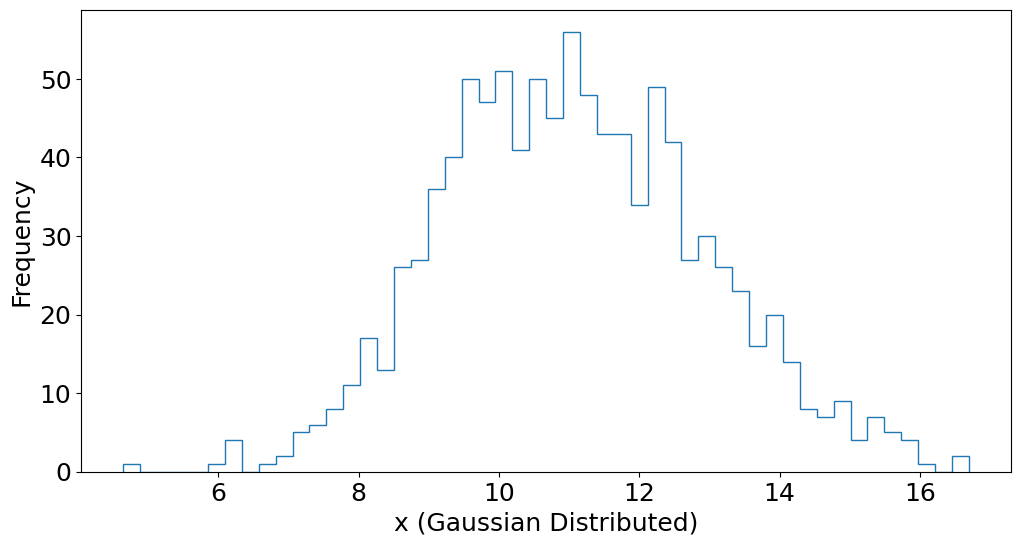

In [28]:
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.hist(t, bins=50, histtype='step', label='histogram' )
ax2.set(xlabel="x (Gaussian Distributed)", ylabel="Frequency");

In [29]:
def gauss_fit(x,sigma, mu, N):
    return  N*(np.exp(-(x-mu)**2/(2*sigma**2)))/ (sigma*np.sqrt(2*np.pi))

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(t, bins=50)
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
sy = sy[y>0]
y = y[y>0]

chi2fit = Chi2Regression(gauss_fit, x, y, sy)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

minuit_chi2 = Minuit(chi2fit,sigma=3, mu = 11, N =100)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad()

chi2_value = minuit_chi2.fval
N_NotEmptyBin = np.sum(y>0)
Ndof_value = N_NotEmptyBin - len(minuit_chi2.parameters)

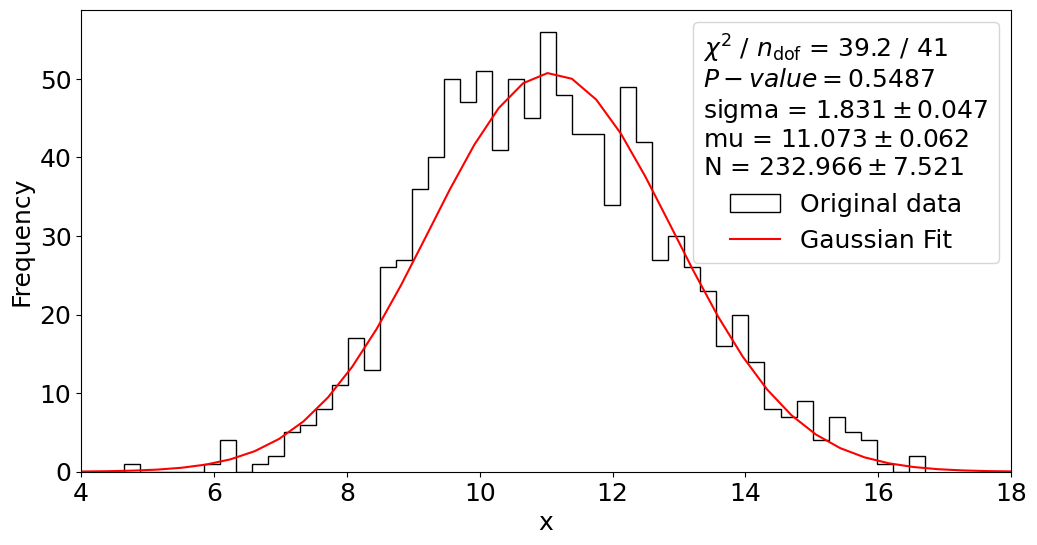

In [30]:


fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {minuit_chi2.fval:.1f} / {len(x) - minuit_chi2.nfit}",f"$P-value = {np.round(stats.chi2.sf(chi2_value,Ndof_value),4)}$"]
for p, v, e in zip(minuit_chi2.parameters, minuit_chi2.values, minuit_chi2.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(t, bins=50, histtype='step', label='Original data', color = 'Black')
ax.errorbar(np.linspace(0,18), gauss_fit(np.linspace(0,18),*minuit_chi2.values),label = 'Gaussian Fit', color = 'Red')
ax.set_xlim(4,18)
ax.set(xlabel="x", ylabel="Frequency");
ax.legend(title="\n".join(fit_info));
